In [1]:
import numpy as np
import mtalg
from mtalg.random import MultithreadedRNG
import pickle
from tqdm import tqdm
import scipy
import cupy
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#Call coin-press functions from repo https://github.com/twistedcubic/coin-press
from utils_cp import fineMeanEst, privateRangeEst, twoShot
viridis = cm.get_cmap('viridis', 8)


In [2]:

#The following functions are taken from the coin-press repo: https://github.com/twistedcubic/coin-press
def cov_est_step(X, A, rho, cur_iter, args):
    """
    One step of multivariate covariance estimation, scale cov a.
    """
    W = torch.mm(X, A)
    n = args.n
    d = args.d

    #Hyperparameters
    gamma = gaussian_tailbound(d, 0.1)
    eta = 0.5*(2*(np.sqrt(d/n)) + (np.sqrt(d/n))**2)
    
    #truncate points
    W_norm = np.sqrt((W**2).sum(-1, keepdim=True))
    norm_ratio = gamma / W_norm
    large_norm_mask = (norm_ratio < 1).squeeze()
    
    W[large_norm_mask] = W[large_norm_mask] * norm_ratio[large_norm_mask]
    #noise
    Y = torch.randn(d, d)
    noise_var = (gamma**4/(rho*n**2))
    Y *= np.sqrt(noise_var)    
    #can also do Y = torch.triu(Y, diagonal=1) + torch.triu(Y).t()
    Y = torch.triu(Y)
    Y = Y + Y.t() - Y.diagonal().diag_embed() #Don't duplicate diagonal entries
    Z = (torch.mm(W.t(), W))/n
    #add noise    
    Z = Z + Y
    #ensure psd of Z
    Z = utils.psd_proj_symm(Z)
    
    U = Z + eta*torch.eye(d)
    inv = torch.inverse(U)
    invU, invD, invV = inv.svd()
    inv_sqrt = torch.mm(invU, torch.mm(invD.sqrt().diag_embed(), invV.t()))
    A = torch.mm(inv_sqrt, A)
    return A, Z

def cov_est(X, args ):
    """
    Multivariate covariance estimation.
    Returns: zCDP estimate of cov.
    """
    A = torch.eye(args.d) / np.sqrt(args.u)
    assert len(args.rho) == args.t
    
    for i in range(args.t-1):
        A, Z = cov_est_step(X, A, args.rho[i], i, args)
    A_t, Z_t = cov_est_step(X, A, args.rho[-1], args.t-1, args)
    
    cov = torch.mm(torch.mm(A.inverse(), Z_t), A.inverse())
    return cov

def gaussian_tailbound(d,b):
    return ( d + 2*( d * np.log(1/b) )**0.5 + 2*np.log(1/b) )**0.5

def mahalanobis_dist(M, Sigma):
    Sigma_inv = torch.inverse(Sigma)
    U_inv, D_inv, V_inv = Sigma_inv.svd()
    Sigma_inv_sqrt = torch.mm(U_inv, torch.mm(D_inv.sqrt().diag_embed(), V_inv.t()))
    M_normalized = torch.mm(Sigma_inv_sqrt, torch.mm(M, Sigma_inv_sqrt))
    return torch.norm(M_normalized - torch.eye(M.size()[0]), 'fro')

''' 
Functions for mean estimation
'''

##    X = dataset
##    c,r = prior knowledge that mean is in B2(c,r)
##    t = number of iterations
##    Ps = 
def multivariate_mean_iterative(X, c, r, t, Ps):
    for i in range(t-1):
        c, r = multivariate_mean_step(X, c, r, Ps[i])
    c, r = multivariate_mean_step(X, c, r, Ps[t-1])
    return c

def multivariate_mean_step(X, c, r, p):
    n, d = X.shape

    ## Determine a good clipping threshold
    gamma = gaussian_tailbound(d,0.01)
    clip_thresh = min((r**2 + 2*r*3 + gamma**2)**0.5,r + gamma) #3 in place of sqrt(log(2/beta))
        
    ## Round each of X1,...,Xn to the nearest point in the ball B2(c,clip_thresh)
    x = X - c
    mag_x = np.linalg.norm(x, axis=1)
    outside_ball = (mag_x > clip_thresh)
    x_hat = (x.T / mag_x).T
    X[outside_ball] = c + (x_hat[outside_ball] * clip_thresh)
    
    ## Compute sensitivity
    delta = 2*clip_thresh/float(n)
    sd = delta/(2*p)**0.5
    
    ## Add noise calibrated to sensitivity
    Y = np.random.normal(0, sd, size=d)
    c = np.sum(X, axis=0)/float(n) + Y
    r = ( 1/float(n) + sd**2 )**0.5 * gaussian_tailbound(d,0.01)
    return c, r

def L1(est): # assuming 0 vector is gt
    return np.sum(np.abs(est))
    
def L2(est): # assuming 0 vector is gt
    return np.linalg.norm(est)

# checking
# multivariate_mean_iterative(mtalg.random.standard_normal(size=(10,10)), 0,1, 1, [0.5])



In [3]:
# This is the expit or sigmoid function with smoothing parameter "smooth" (1+exp(-smooth*x))^{-1}
def expit(x,smooth):
    return scipy.special.expit(x*smooth)

# Computes the smoothed integrated dual depth
# x: d x 1 numpy array for point at which depth is computed
# u: m x d numpy array of uniformly sampled unit vectors
# pj_data: n  x m numpy array of projections of data onto u
# n: integer sample size
def idd_beta(x,smooth,pj_data,u,n):
    # pj_data=np.matmul(data,u)
    pj_x=np.matmul(u,x)
    # Now for each u find univariate depth and average, u are the columns
    depth= expit(pj_x-pj_data,smooth)
    depth= np.sum(depth,0)/n
    depth= depth*(1-depth)
    depth= np.mean(depth)
    return depth


# Computes the gradient of the smoothed integrated dual depth
# x: d x 1 numpy array for point at which depth is computed
# u: m x d numpy array of uniformly sampled unit vectors
# pj_data: n  x m numpy array of projections of data onto u
# smooth: float, value of the smoothing parameter "s"
# m: integer number of unit vectors sampled
# n: integer sample size
def grad_depth(x,pj_data,u,smooth,n,m):
    x=cupy.asarray(x)
    # pj_data=np.matmul(data,u)
    # pj data is n  x m
    # pj x is m x 1
    # x is d x 1
    # u m x d
    pj_x=cupy.matmul(u,x)
    #expits is n x m 
    expits=expit(pj_x-pj_data,smooth)  
    term1= expits*(1-expits)
    # sum/mean along the columns now
    term1=cupy.sum(term1,0)/n
    term2=1-2*cupy.sum(expits,0)/n
    ddx=term1*term2*smooth
    # Now ddx is "1 x m" but is a vector
    # multiply each column of u by ddx 
    grad=(u.T)*ddx
    grad=cupy.sum(grad,1)/m
    # final=n*eps* uv/2
    return cupy.asnumpy(grad)


#Gradient of the log density of a normal prior 
# x: d x 1 numpy array for point at which depth is computed
# prior_mean: d x 1 numpy array representing the prior mean
# prior_cov_inv: d x d numpy array representing the inverse of the prior covariance matrix
def grad_prior(x,prior_mean,prior_cov_inv):
    return -np.matmul(x-prior_mean,prior_cov_inv)


# Gradient descent algorithm for computing the non-private smoothed IDD median 
# x: d x 1 numpy array for point at which depth is computed
# u: m x d numpy array of uniformly sampled unit vectors
# pj_data: n  x m numpy array of projections of data onto u
# smooth: float, value of the smoothing parameter "s"
# m: integer number of unit vectors sampled
# n: integer sample size
# eps: pure privacy parameter
def GD_update(x,step,d,pj_data,smooth,n,m,unit_vectors):
    return x+step*(grad_depth(x,pj_data,unit_vectors,smooth,n,m))

######
### one step of langevin dynamics
## 
# x: d x 1 numpy array for point at which depth is computed
# step: step size for the langevin dynamics
# sqrt2step: just sqrt(2*step)
# d: integer dimension
# pj_data: n  x m numpy array of projections of data onto u
# smooth: float, value of the smoothing parameter "s"
# n: integer sample size
# m: integer number of unit vectors sampled
# unit_vectors: m x d numpy array of uniformly sampled unit vectors
# eps: pure privacy parameter
# prior_mean: d x 1 numpy array representing the prior mean
# prior_cov_inv: d x d numpy array representing the inverse of the prior covariance matrix
# mrng: this is the seed for the mtalg package
def langevin_update(x,step,sqrt2step,d,pj_data,smooth,n,m,unit_vectors,eps,prior_mean,prior_cov_inv,mrng):
    prior_grad=grad_prior(x,prior_mean,prior_cov_inv)
    depth_grad=grad_depth(x,pj_data,unit_vectors,smooth,n,m)
    # beta=eps*n/6 ensures eps-DP for smoothed IDD 
    return x+step*(prior_grad+depth_grad*eps*n/6)+sqrt2step*mrng.standard_normal(size=d)



In [6]:
########### Generate the datasets, unit vectors for the IDD median and starting values for the MCMC/GD and save in folders
########## This is useful for reproducibility and makes the code slightly faster
#Number of runs in the experiment
num_runs=50
#maximum dimension analysed
d=100
#sample size
ndata=10000
#portion of data contaminated
con_level=0.25


##### First generate the datasets and pickle them #####
# Build a contaminating matrix to add to data to create contaminated datasets
#number of observations contaminated
total=int(con_level*ndata)
# matrix of 5s with total rows
mean_contam=np.full((total,d),5)
# matrix of 0s with n-total rows
mean_clean=np.full((ndata-total,d),0)
# n x d matrix with con_level of rows equal to 5, the rest 0
contam_mat=np.vstack([mean_contam,mean_clean])

# This allows us to set the seed with the mtalg package
mrng = MultithreadedRNG(seed=421, num_threads=10)

#generate the data and write to files
for run in tqdm(range(num_runs)):
    #the clean dataset
    data_clean=mrng.standard_normal(size=(ndata,d))
    #add contamination matrix
    data_con=data_clean+contam_mat
    #now pickle it for reloading later
    #pickle 1
    fn="data/data_set_clean_"+str(run)+".pickle"
    with open(fn,"wb") as file:
        pickle.dump(data_clean,file)
    #pickle 2
    fn="data/data_set_con_"+str(run)+".pickle"
    with open(fn,"wb") as file:
        pickle.dump(data_con,file)


##### Second generate the unit vectors to be used with s-IDD ##### 
#number of unit vectors
nvec=500
#dimensions in the experiment
dimensions=[2,10,20,50,100]

# This allows us to set the seed with the mtalg package
mrng = MultithreadedRNG(seed=422, num_threads=10)
# Generate unit vectors and save them for later
for d in tqdm(dimensions):
    for run in range(num_runs):
        unit_vectors=mrng.standard_normal(size=(nvec,d))
        for i in range(0,nvec):
            unit_vectors[i,:]=unit_vectors[i,:]/np.linalg.norm(unit_vectors[i,:])
    #now pickle it for reloading
        fn="unit_vectors/unit_vectors_dimension_"+str(d)+"_run_"+str(run)+".pickle"
        with open(fn,"wb") as file:
            pickle.dump(unit_vectors,file)



#### Third generate the starting values for langevin and gradient descent #### 

mrng = MultithreadedRNG(seed=423, num_threads=10)
#generate uv and save them for later
for d in tqdm(dimensions):
    for run in range(num_runs):
        start=mrng.standard_normal(size=d)
    #now pickle it for reloading
        fn="starting/starting_dimension_"+str(d)+"_run_"+str(run)+".pickle"
        with open(fn,"wb") as file:
            pickle.dump(start,file)




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


In [138]:

# This function returns one run of the simulation experiment for a given run_number
# OUTPUT:
# x:  the Markov chain for the private median 
# x2: the iterations of the gradient descent for the non-private median 
# cp: coin-press mean 
# INPUT: 
# run_number: the number from 1-50 corresponding to the simulation run
# d: integer dimension
# eps: pure privacy parameter
# smooth: float, value of the smoothing parameter "s"
# x: d x 1 numpy array for point at which depth is computed
# nvec: integer number of unit vectors sampled
# ndata: integer sample size
# step: step size for the langevin dynamics
# sqrt2step: just sqrt(2*step)
# prior_mean: d x 1 numpy array representing the prior mean
# prior_cov_inv: d x d numpy array representing the inverse of the prior covariance matrix
# n_steps_gd: Number of iterations in the gradient descent for the non-private median
# n_steps_mc:Number of iterations in the langevin dynamics for the private median
# step_g: step size for the gradient descent for the non-private median
# step_l: step size for the langevin dynamics for the private median
# data_type: either 'clean' for the uncontaminated simulation or 'con' for the contaminated simulation
def experiment(run_number,d,eps,smooth,nvec,ndata,prior_mean,prior_cov_inv,n_steps_gd,n_steps_mc,step_g,step_l,data_type='clean'):
    # set the seed for the langevin dynamics to be the run number
    # this way we can reproduce the chain 
    # only use 1 thread because we are on the gpu
    mrng = MultithreadedRNG(seed=run_number, num_threads=1)
    # load in data, unit vectors and starting value
    with open("data/data_set_"+data_type+"_"+str(run_number)+".pickle",'rb') as file:
        data=pickle.load(file)
    data=data[:,0:d]
    with open("unit_vectors/unit_vectors_dimension_"+str(d)+"_run_"+str(run_number)+".pickle",'rb') as file:
        unit_vectors=pickle.load(file)
    with open("starting/starting_dimension_"+str(d)+"_run_"+str(run_number)+".pickle",'rb') as file:
        x0=pickle.load(file)
    # compute the projections of the data onto the randomly drawn unit vectors
    pj_data=np.matmul(unit_vectors,data.T).T
    # move projections and unit vectors to GPU, you must have an Nvidia gpu with cuda installed
    pj_data=cupy.asarray(pj_data)
    unit_vectors=cupy.asarray(unit_vectors)
    
    ###### MCMC-lagevin dyanmics for private median
    x = []
    x.append(x0)
    sqrt2step = np.sqrt(2*step_l)
    for t in range(n_steps_mc):
        x.append(langevin_update(x[-1],step_l,sqrt2step,d,pj_data,smooth,ndata,nvec,unit_vectors,eps,prior_mean,prior_cov_inv,mrng))
    
    ###### Gradient Descent for non-private median
    x2= []
    x2.append(x0)
    # np.random.normal(0,1,d))
    for t in range(n_steps_gd):
        x2.append(GD_update(x2[-1],step_g,d,pj_data,smooth,ndata,nvec,unit_vectors))
    ####### Computing the coin-press mean
    # p is the concentrated differential privacy parameter for coin-press
    p=eps**2/2
    cp=multivariate_mean_iterative(data, 0,10*np.sqrt(d), 4,  [(1.0/12.0)*p, (1.0/12.0)*p, (1.0/12.0)*p, (3.0/4.0)*p])
    
    return x,x2,cp

# This function plots and saves the results from each experiment. 
# It writes the progression of the GD and MCMC to text files, the mean to a text file
# It plots the chains over time with the cp mean overlaid
# INPUT: 
# results: list of results from 50 runs of the simulations
# d: integer dimension
# n_steps_gd: Number of iterations in the gradient descent for the non-private median
# n_steps_mc:Number of iterations in the langevin dynamics for the private median
# step_g: step size for the gradient descent for the non-private median
# step_l: step size for the langevin dynamics for the private median
# data_type: either 'clean' for the uncontaminated simulation or 'con' for the contaminated simulation
def plot_and_save(results,d,n_steps_gd,n_steps_mc,data_type='clean'):
    pr_est=np.zeros(d)
    np_est=np.zeros(d)
    colors= viridis(range(8))
    count=0
    for i in results:
        x_p,x_np,cp = i
        #pr
        x_p = np.array(x_p)
        norm_x_p = np.apply_along_axis(np.linalg.norm, 1, x_p)
        pr_est=np.vstack([pr_est,x_p[n_steps_mc-1,:]])
        ##np
        x_np = np.array(x_np)
        norm_x_np = np.apply_along_axis(np.linalg.norm, 1, x_np)
        np_est=np.vstack([np_est,x_np[n_steps_gd-1,:]])
        #Cp
        if count==0:
            plt.plot(np.arange(x_p.shape[0]),norm_x_p,color=colors[0],label=r'private')
            plt.plot(np.arange(x_np.shape[0]),norm_x_np,color=colors[4],label=r'non-private')
            plt.hlines(np.linalg.norm(cp),0,x_p.shape[0],color=colors[2],label=r'coin-press')
            plt.ylabel('estimate norm', fontsize=18)
            plt.xlabel('time step', fontsize=18)
            plt.legend(fontsize=18)
        else:
            plt.plot(np.arange(x_p.shape[0]),norm_x_p,color=colors[0])
            plt.plot(np.arange(x_np.shape[0]),norm_x_np,color=colors[4])
            plt.hlines(np.linalg.norm(cp),0,x_p.shape[0],color=colors[2])
        count=count+1
    # plt.show()
    #save the plot
    fname='out_img/dimension_'+str(d)+"_"+data_type+"_gaussian.png"
    plt.savefig(fname,dpi=600)
    plt.show()
    #save the estimates to a csv
    fn_p="output/private_results_dimension_"+str(d)+"_"+data_type+".csv"
    fn_p=open(fn_p, 'w', newline='')
    np.savetxt(fn_p, pr_est, delimiter=",")   
    fn_p.close()
    fn_np="output/non_private_results_dimension_"+str(d)+"_"+data_type+".csv"
    fn_np=open(fn_np, 'w', newline='')
    np.savetxt(fn_np, np_est, delimiter=",")
    fn_np.close()
    fn_cp="output/coin_press_results_dimension_"+str(d)+"_"+data_type+".csv"
    fn_cp=open(fn_cp, 'w', newline='')
    np.savetxt(fn_cp, cp, delimiter=",")
    fn_cp.close()



In [139]:
#prelinminary experiment parameters
d=100
num_runs=int(50)
ndata=10000
nvec=200
nsteps_gd=[100,500,1000,4000,8000]
nsteps_mc=nsteps_gd
gd_step_sizes=[2.5,2,2,1.5,1.5]
dimensions=[2,10,20,50,100]


starting dimension 2


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:46<00:00,  1.07it/s]


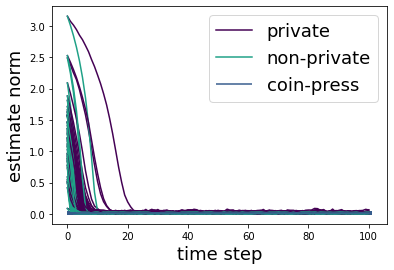

starting dimension 10


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:48<00:00,  4.56s/it]


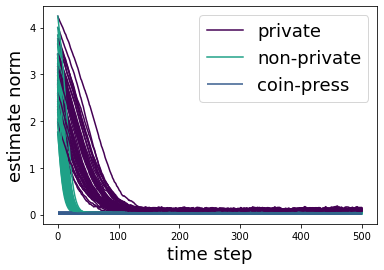

starting dimension 20


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [07:26<00:00,  8.94s/it]


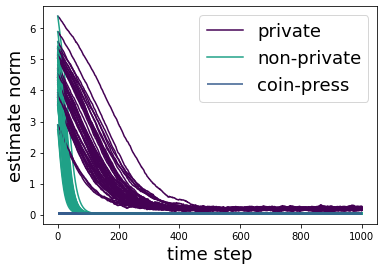

starting dimension 50


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [29:44<00:00, 35.68s/it]


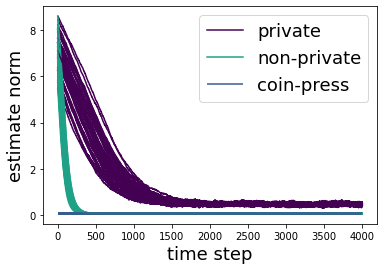

starting dimension 100


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:01:57<00:00, 74.34s/it]


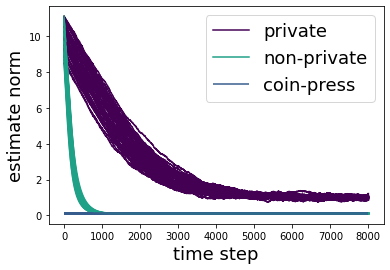

In [140]:

# Simplified wrapper for the experiment function for the clean experiment with identity prior covariance
def m_experiment(run_number,d,gd_step,nstep):
    x_p,x_np,cp=experiment(run_number,d,10,10,nvec,ndata,np.zeros(d),np.eye(d),nstep,nstep,gd_step,0.0001/np.sqrt(d),data_type='clean')
    return x_p,x_np,cp


# run the experiment for the clean data
for i in range(len(dimensions)):
    d=dimensions[i]
    print('starting dimension '+str(d))
    gd_step=gd_step_sizes[i]
    nstep=nsteps_gd[i]
    if __name__=="__main__":
        results=[]
        for j in tqdm(range(num_runs)):
            results.append(m_experiment(j,d,gd_step,nstep))
        plot_and_save(results,d,nstep,nstep)
        # #save the chains too in case we want to modify the graphs
        fn="output/results_clean_dimension_"+str(d)+".pickle"
        with open(fn,"wb") as file:
            pickle.dump(results,file)



starting dimension 2


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s]


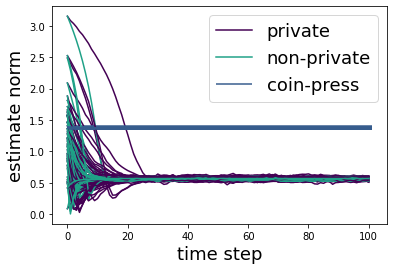

starting dimension 10


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:48<00:00,  4.56s/it]


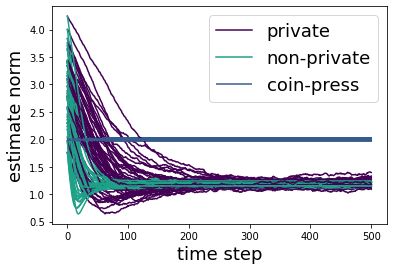

starting dimension 20


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [07:52<00:00,  9.44s/it]


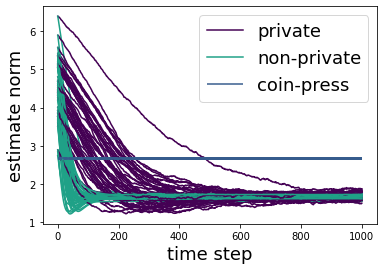

starting dimension 50


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [30:37<00:00, 36.75s/it]


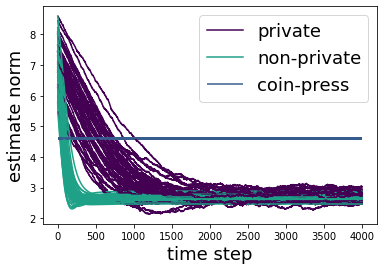

starting dimension 100


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:03:43<00:00, 76.47s/it]


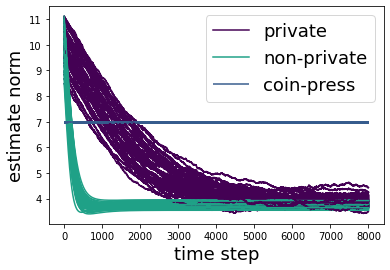

In [141]:
# Simplified wrapper for the experiment function for the contaminated experiment with identity prior covariance
def m_experiment(run_number,d,gd_step,nstep):
    x_p,x_np,cp=experiment(run_number,d,10,10,nvec,ndata,np.zeros(d),np.eye(d),nstep,nstep,gd_step,0.0001/np.sqrt(d),data_type='con')
    return x_p,x_np,cp

# Run the contaminated experiment
for i in range(len(dimensions)):
    d=dimensions[i]
    print('starting dimension '+str(d))
    gd_step=gd_step_sizes[i]
    nstep=nsteps_gd[i]
    if __name__=="__main__":
        results=[]
        for j in tqdm(range(num_runs)):
            results.append(m_experiment(j,d,gd_step,nstep))
        plot_and_save(results,d,nstep,nstep,data_type='con')
        # #save the chains too in case we want to modify the graphs
        fn="output/results_con_dimension_"+str(d)+".pickle"
        with open(fn,"wb") as file:
            pickle.dump(results,file)



starting dimension 2


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.06it/s]


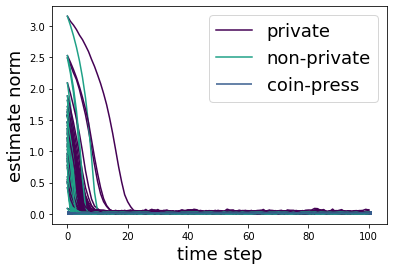

starting dimension 10


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:48<00:00,  4.57s/it]


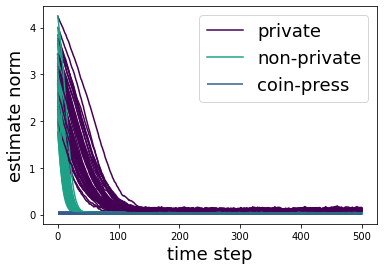

starting dimension 20


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [07:31<00:00,  9.03s/it]


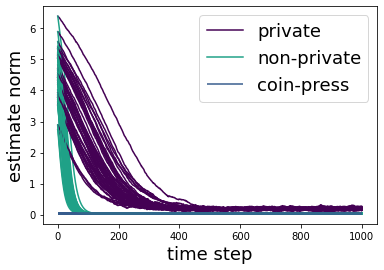

starting dimension 50


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [30:54<00:00, 37.08s/it]


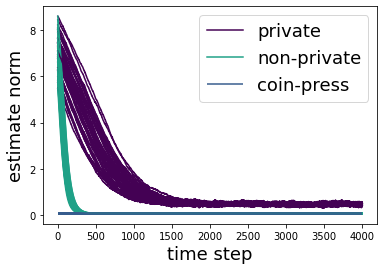

starting dimension 100


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:02:56<00:00, 75.52s/it]


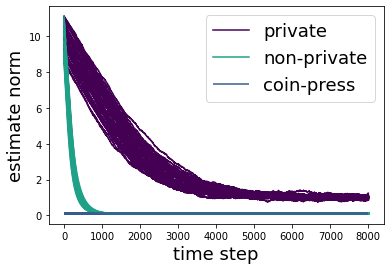

In [142]:
#higher variance prior

# Simplified wrapper for the experiment function for the clean experiment
def m_experiment(run_number,d,gd_step,nstep):
    x_p,x_np,cp=experiment(run_number,d,10,10,nvec,ndata,np.zeros(d),np.eye(d)/(25*d),nstep,nstep,gd_step,0.0001/np.sqrt(d),data_type='clean')
    return x_p,x_np,cp


for i in range(len(dimensions)):
    d=dimensions[i]
    print('starting dimension '+str(d))
    gd_step=gd_step_sizes[i]
    nstep=nsteps_gd[i]
    if __name__=="__main__":
        results=[]
        for j in tqdm(range(num_runs)):
            results.append(m_experiment(j,d,gd_step,nstep))
        plot_and_save(results,d,nstep,nstep,data_type="mis_prior")
        # #save the chains too in case we want to modify the graphs
        fn="output/results_mis_prior_dimension_"+str(d)+".pickle"
        with open(fn,"wb") as file:
            pickle.dump(results,file)



starting dimension 2


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:45<00:00,  1.09it/s]


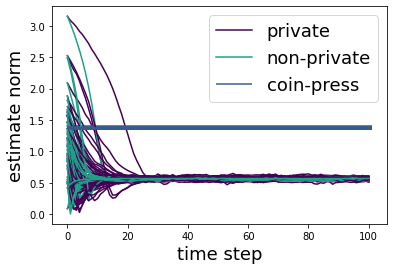

starting dimension 10


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:13<00:00,  6.26s/it]


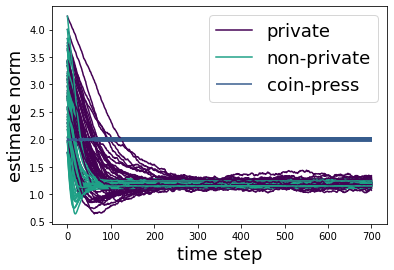

starting dimension 20


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [11:08<00:00, 13.37s/it]


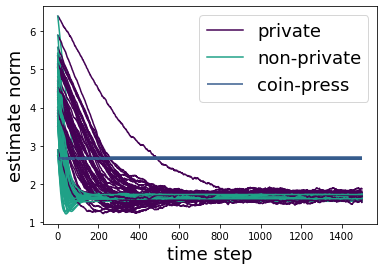

starting dimension 50


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [44:34<00:00, 53.50s/it]


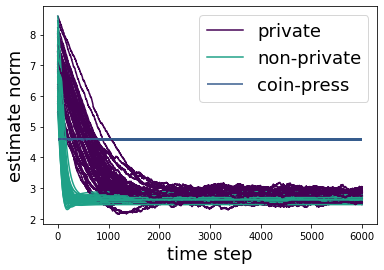

starting dimension 100


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [2:02:58<00:00, 147.56s/it]


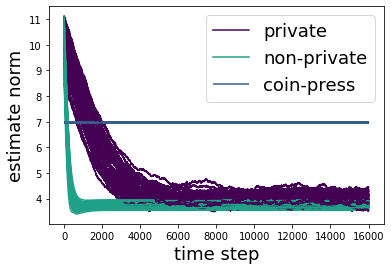

In [143]:
#changing the step sizes to be a little longer
nsteps_gd=[100,700,1500,6000,16000]
nsteps_mc=nsteps_gd

# Simplified wrapper for the experiment function for the contaminated experiment
def m_experiment(run_number,d,gd_step,nstep):
    x_p,x_np,cp=experiment(run_number,d,10,10,nvec,ndata,np.zeros(d),np.eye(d)/(25*d),nstep,nstep,gd_step,0.0001/np.sqrt(d),data_type='con')
    return x_p,x_np,cp

for i in range(len(dimensions)):
    d=dimensions[i]
    print('starting dimension '+str(d))
    gd_step=gd_step_sizes[i]
    nstep=nsteps_gd[i]
    if __name__=="__main__":
        results=[]
        for j in tqdm(range(num_runs)):
            results.append(m_experiment(j,d,gd_step,nstep))
        plot_and_save(results,d,nstep,nstep,data_type="mis_prior_con")
        # #save the chains too in case we want to modify the graphs
        fn="output/results_mis_prior_con_dimension_"+str(d)+".pickle"
        with open(fn,"wb") as file:
            pickle.dump(results,file)



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [32:07<00:00, 38.56s/it]


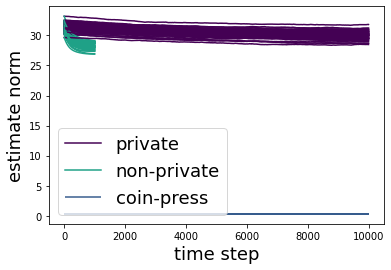

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [32:28<00:00, 38.97s/it]


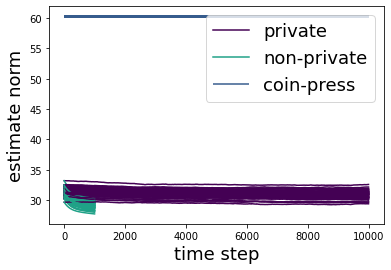

In [103]:
#higher variance prior with 1000 dimensions
d=1000
# /np.sqrt(d)
###setting up to run multiprocessing
def m_experiment(run_number,d,gd_step,nstep):
    x_p,x_np,cp=experiment(run_number,d,10,10,nvec,ndata,np.zeros(d),np.eye(d)/(25*d),1000,nstep,gd_step,0.0001/np.sqrt(d),data_type='clean')
    return x_p,x_np,cp

d=1000
gd_step=5
nstep=10000
if __name__=="__main__":
    results=[]
    for j in tqdm(range(50)):
        results.append(m_experiment(j,d,gd_step,nstep))
    plot_and_save(results,d,1000,nstep,data_type="mis_prior")
        # #save the chains too in case we want to modify the graphs
    fn="output/results_mis_prior_clean_dimension_"+str(d)+".pickle"
    with open(fn,"wb") as file:
        pickle.dump(results,file)

    ###setting up to run multiprocessing
def m_experiment(run_number,d,gd_step,nstep):
    x_p,x_np,cp=experiment(run_number,d,10,10,nvec,ndata,np.zeros(d),np.eye(d)/(25*d),1000,nstep,gd_step,0.0001/np.sqrt(d),data_type='con')
    return x_p,x_np,cp

if __name__=="__main__":
    results=[]
    for j in tqdm(range(50)):
        results.append(m_experiment(j,d,gd_step,nstep))
    plot_and_save(results,d,1000,nstep,data_type="mis_prior_con")
    fn="output/results_mis_prior_con_dimension_"+str(d)+".pickle"
    with open(fn,"wb") as file:
        pickle.dump(results,file)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:12<00:00,  2.05it/s]


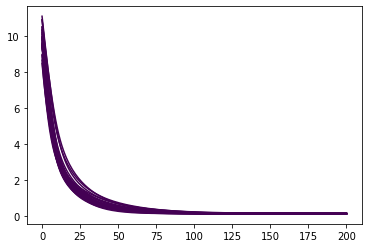

In [88]:
#Testing the run time of the nonprivate median
def experiment_run_time(run_number,d,eps,smooth,nvec,ndata,n_steps_gd,step_g,data_type='clean'):
    #load in data
    mrng = MultithreadedRNG(seed=run_number, num_threads=1)
    with open("data/data_set_"+data_type+"_"+str(run_number)+".pickle",'rb') as file:
        data=pickle.load(file)
    data=data[:,0:d]
    with open("unit_vectors/unit_vectors_dimension_"+str(d)+"_run_"+str(run_number)+".pickle",'rb') as file:
        unit_vectors=pickle.load(file)
    with open("starting/starting_dimension_"+str(d)+"_run_"+str(run_number)+".pickle",'rb') as file:
        x0=pickle.load(file)
    #compute data projections only once onto random unit vectors
    pj_data=np.matmul(unit_vectors,data.T).T
    #move to GPU, you must have an nvidia gpu with cuda installed
    pj_data=cupy.asarray(pj_data)
    unit_vectors=cupy.asarray(unit_vectors)
    ###### MCMC
    x2= []
    x2.append(x0)
    # np.random.normal(0,1,d))
    for t in range(n_steps_gd):
        x2.append(GD_update(x2[-1],step_g,d,pj_data,smooth,ndata,nvec,unit_vectors,eps))
    return np.array(x2)

colors= viridis(range(8))
d=100
gd_step=100
nstep=200
results=[]
for j in tqdm(range(25)):
    x2=experiment_run_time(j,d,10,10,nvec,ndata,nstep,gd_step)
    plt.plot(np.arange(x2.shape[0]),np.apply_along_axis(np.linalg.norm, 1, x2),color=viridis(range(1))[0])
plt.show()

In [130]:
#compute the non-priavte sample mean
def experiment_mean(run_number,d,data_type='clean'):
    #load in data
    with open("data/data_set_"+data_type+"_"+str(run_number)+".pickle",'rb') as file:
        data=pickle.load(file)
    data=data[:,0:d]
    # p is the concentrated privacy parameter for coin-press
    mean=np.mean(data,0)
    print(mean.shape)
    return mean

data_type='clean'

# dimensions=[2,10]
for i in range(len(dimensions)):
    d=dimensions[i]
    if __name__=="__main__":
        results_mean=[]
        for j in tqdm(range(num_runs)):
            results_mean.append(experiment_mean(j,d,data_type))
        # #save the chains too in case we want to modify the graphs
        fn="output/np_mean_"+data_type+"_"+str(d)+".pickle"
        with open(fn,"wb") as file:
            pickle.dump(results_mean,file)

data_type='con'
# dimensions=[2,10]
for i in range(len(dimensions)):
    d=dimensions[i]
    if __name__=="__main__":
        results_mean=[]
        for j in tqdm(range(num_runs)):
            results_mean.append(experiment_mean(j,d,data_type))
        # #save the chains too in case we want to modify the graphs
        fn="output/np_mean_"+data_type+"_"+str(d)+".pickle"
        with open(fn,"wb") as file:
            pickle.dump(results_mean,file)



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 410.94it/s]


50


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2088.76it/s]


50


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 10027.02it/s]


50


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2086.80it/s]


50


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 964.09it/s]


50


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 220.85it/s]


50


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.70it/s]


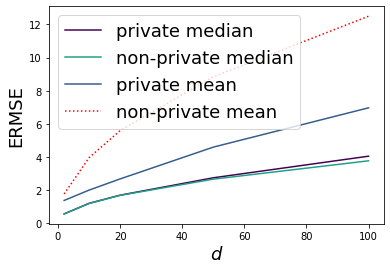

In [8]:
# Now make graphs for manuscript
viridis = cm.get_cmap('viridis', 8)
colors= viridis(range(8))
d=10
def get_mses(d):
    fn="output/results_mis_prior_con_dimension_"+str(d)+".pickle"
    with open(fn,"rb") as file:
        results=pickle.load(file)
    print(len(results))
    x_p_mse=0
    x_np_mse=0
    x_cp_mse=0
    for i in tqdm(results):
        x_p,x_np,x_cp = i
        x_p = np.array(x_p)
        x_np = np.array(x_np)
        x_cp = np.array(x_cp)
        # print(x_p.shape)
        # print(x_np.shape)
        # print(x_cp.shape)
        x_p_mse=x_p_mse+np.linalg.norm(x_p[x_p.shape[0]-1,:])**2
        x_np_mse=x_np_mse+np.linalg.norm(x_np[x_np.shape[0]-1,:])**2
        x_cp_mse=x_cp_mse+np.linalg.norm(x_cp)**2
    
    x_p_mse=x_p_mse/len(results)
    x_np_mse=x_np_mse/len(results)
    x_cp_mse=x_cp_mse/len(results)
    
    
    
    fn_m="output/np_mean_con_"+str(d)+".pickle"
    with open(fn_m,"rb") as file:
        results_mean=pickle.load(file)
    x_npm_mse=np.mean(np.apply_along_axis(np.linalg.norm, 1, results_mean)**2)

    # print(x_p_mse)
    # print(x_np_mse)
    # print(x_cp_mse)
    # print(x_npm_mse)
    return x_p_mse, x_np_mse, x_cp_mse, x_npm_mse


get_mses(d)
dimensions=[2,10,20,50,100]
mses1=[]
mses2=[]
mses3=[]
mses4=[]
for d in dimensions:
    ms1,ms2,ms3,ms4=get_mses(d)
    mses1.append(ms1)
    mses2.append(ms2)
    mses3.append(ms3)
    mses4.append(ms4)

    
# save figure an plot in notebook
plt.plot(dimensions,np.sqrt(mses1),color=colors[0],label=r'private median')
plt.plot(dimensions,np.sqrt(mses2),color=colors[4],label=r'non-private median')
plt.plot(dimensions,np.sqrt(mses3),color=colors[2],label=r'private mean')
plt.plot(dimensions,np.sqrt(mses4),color="red",label=r'non-private mean', linestyle='dotted')
plt.legend(fontsize=18)
# plt.show()
plt.ylabel('ERMSE', fontsize=18)
plt.xlabel(r'$d$', fontsize=18)
fname="con_gaussian.png"
plt.savefig(fname,dpi=600)
plt.show()


50


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2785.32it/s]


50


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 10026.06it/s]


50


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2785.28it/s]


50


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1354.99it/s]


50


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 345.75it/s]


50


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 87.19it/s]


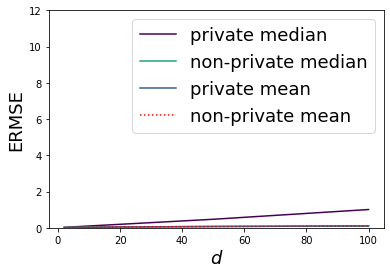

In [9]:
d=10
# function to compute mse of estimates
def get_mses(d):
    fn="output/results_mis_prior_dimension_"+str(d)+".pickle"
    with open(fn,"rb") as file:
        results=pickle.load(file)
    print(len(results))
    x_p_mse=0
    x_np_mse=0
    x_cp_mse=0
    for i in tqdm(results):
        x_p,x_np,x_cp = i
        x_p = np.array(x_p)
        x_np = np.array(x_np)
        x_cp = np.array(x_cp)
        # print(x_p.shape)
        # print(x_np.shape)
        # print(x_cp.shape)
        x_p_mse=x_p_mse+np.linalg.norm(x_p[x_p.shape[0]-1,:])**2
        x_np_mse=x_np_mse+np.linalg.norm(x_np[x_np.shape[0]-1,:])**2
        x_cp_mse=x_cp_mse+np.linalg.norm(x_cp)**2
    
    x_p_mse=x_p_mse/len(results)
    x_np_mse=x_np_mse/len(results)
    x_cp_mse=x_cp_mse/len(results)
    
    
    
    fn_m="output/np_mean_clean_"+str(d)+".pickle"
    with open(fn_m,"rb") as file:
        results_mean=pickle.load(file)
    x_npm_mse=np.mean(np.apply_along_axis(np.linalg.norm, 1, results_mean)**2)
    
    # print(x_p_mse)
    # print(x_np_mse)
    # print(x_cp_mse)
    # print(x_npm_mse)
    return x_p_mse, x_np_mse, x_cp_mse, x_npm_mse

#compute mse
get_mses(d)
dimensions=[2,10,20,50,100]
mses1=[]
mses2=[]
mses3=[]
mses4=[]
for d in dimensions:
    ms1,ms2,ms3,ms4=get_mses(d)
    mses1.append(ms1)
    mses2.append(ms2)
    mses3.append(ms3)
    mses4.append(ms4)

# save plot 
plt.ylim(0,12)
plt.plot(dimensions,np.sqrt(mses1),color=colors[0],label=r'private median')
plt.plot(dimensions,np.sqrt(mses2),color=colors[4],label=r'non-private median')
plt.plot(dimensions,np.sqrt(mses3),color=colors[2],label=r'private mean')
plt.plot(dimensions,np.sqrt(mses4),color='red',label=r'non-private mean', linestyle='dotted')
plt.legend(fontsize=18)
plt.ylabel('ERMSE', fontsize=18)
plt.xlabel(r'$d$', fontsize=18)
fname="clean_gaussian.png"
plt.savefig(fname,dpi=600)
plt.show()
